In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

2025-10-24 09:08:41.343876: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 09:08:41.344150: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 09:08:41.378570: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 09:08:42.268275: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

In [2]:
# Load CSV files
vehicles_df = pd.read_csv('../vehicles.csv')
reservations_df = pd.read_csv('../reservations.csv')

In [3]:
# Display the first few rows of each dataframe to understand their structure
display(vehicles_df.head())
display(reservations_df.head())

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description
0,1,1,67.85,59,5,0,7
1,2,0,100.70,53,5,0,224
2,3,0,74.00,74,4,1,21
3,4,0,135.00,75,1,0,184
4,5,0,59.36,53,2,1,31


,vehicle_id,created_at
0,208,2023-07-27 14:58:26
1,601,2023-04-18 09:36:57
2,993,2023-12-25 01:22:09
3,423,2023-07-26 04:54:19
4,685,2023-11-26 15:21:35


In [4]:
# Aggregate the reservations data to get the total number of reservations per vehicle
reservations_count = reservations_df['vehicle_id'].value_counts().reset_index()
reservations_count.columns = ['vehicle_id', 'total_reservations']

In [5]:
# Merge the aggregated reservations data with the vehicles data
merged_data = pd.merge(vehicles_df, reservations_count, on='vehicle_id', how='left')
merged_data['total_reservations'] = merged_data['total_reservations'].fillna(0)

In [6]:
# Display the first few rows of the merged data
display(merged_data.head())

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,total_reservations
0,1,1,67.85,59,5,0,7,1.0
1,2,0,100.70,53,5,0,224,7.0
2,3,0,74.00,74,4,1,21,17.0
3,4,0,135.00,75,1,0,184,2.0
4,5,0,59.36,53,2,1,31,2.0


In [7]:
# Calculate descriptive statistics for each column
descriptive_stats = merged_data.describe()

In [8]:
# Display descriptive statistics
print("Descriptive Statistics:")
display(descriptive_stats)


Descriptive Statistics:


,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,total_reservations
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,0.170000,87.940730,62.206000,3.008000,0.511000,90.792000,6.376000
std,288.819436,0.375821,29.724589,16.082544,1.348983,0.500129,76.948644,4.861302
min,1.000000,0.000000,32.760000,35.000000,1.000000,0.000000,1.000000,0.000000
25%,250.750000,0.000000,64.942500,49.000000,2.000000,0.000000,25.000000,3.000000
50%,500.500000,0.000000,83.930000,62.000000,3.000000,1.000000,57.500000,5.000000
75%,750.250000,0.000000,107.010000,76.000000,4.000000,1.000000,158.000000,9.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000,25.000000


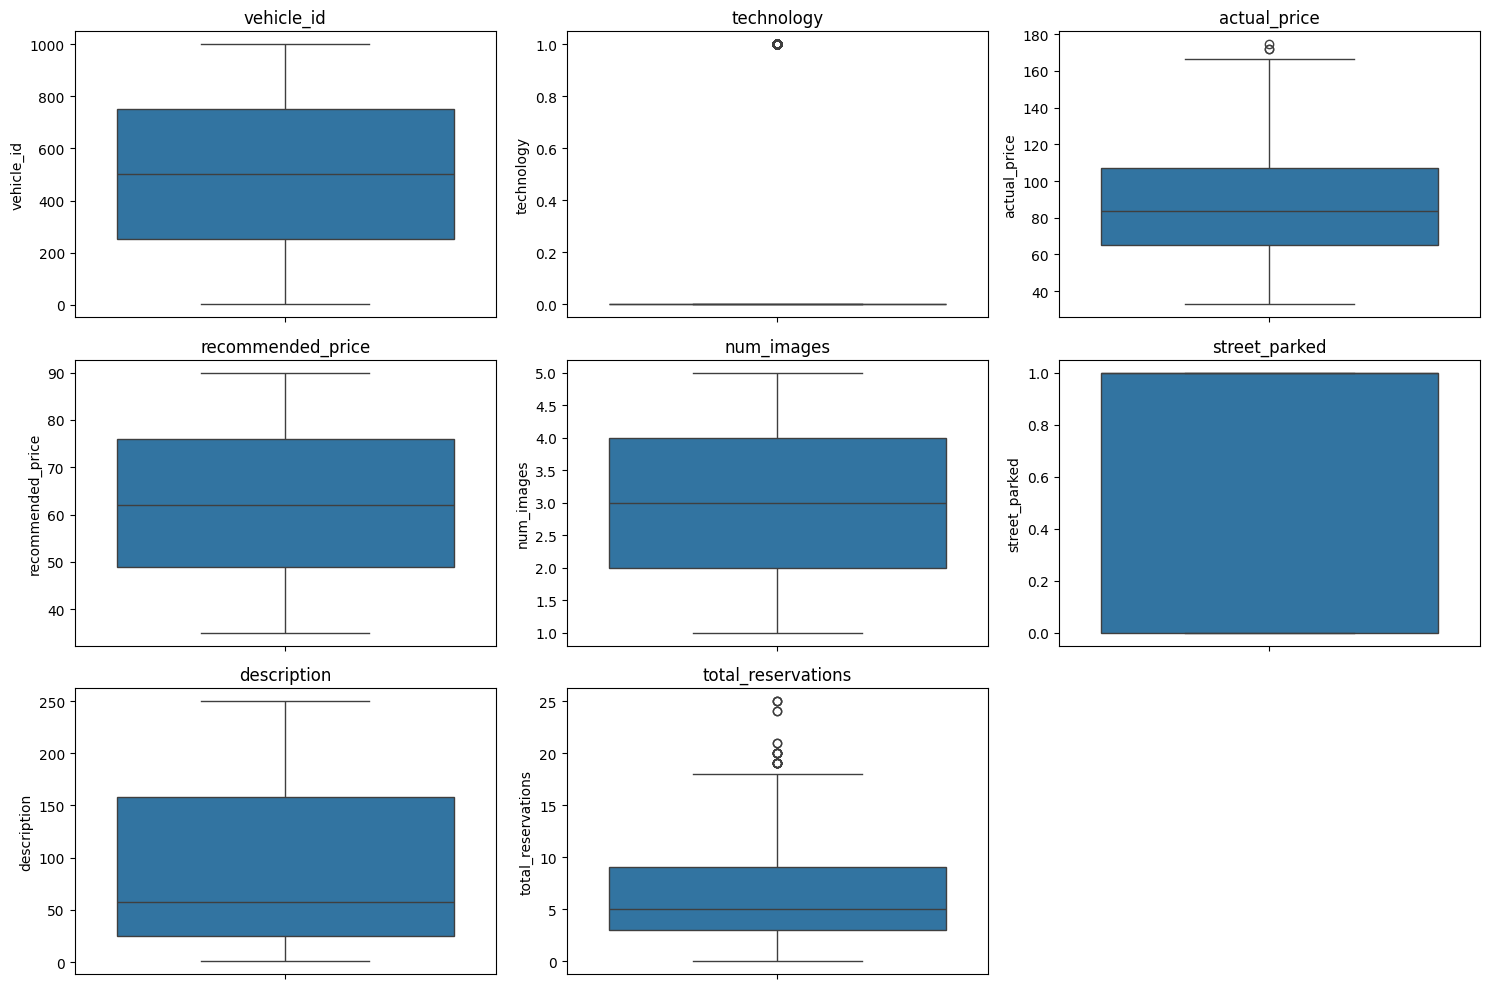

In [9]:
# Plot box plots for each column to identify outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(merged_data.columns):
    if merged_data[column].dtype in [np.dtype('int64'), np.dtype('float64')]:
        plt.subplot(3, 3, i+1)
        sns.boxplot(y=merged_data[column])
        plt.title(column)
plt.tight_layout()
plt.show()

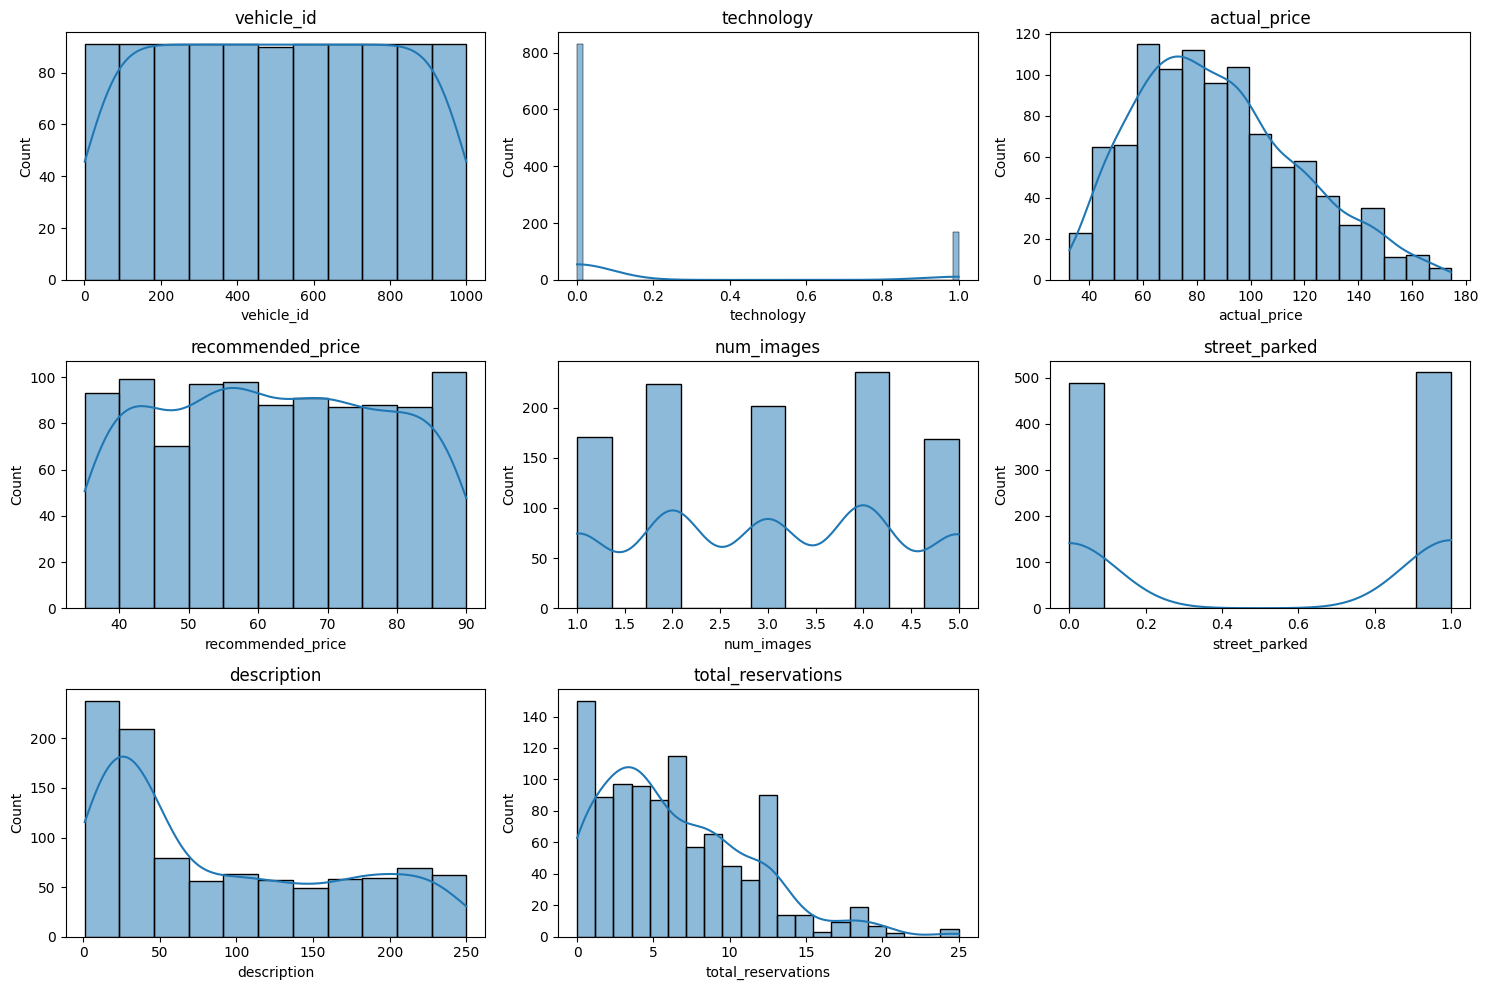

In [10]:
# Plot histograms for each column to understand the distribution
plt.figure(figsize=(15, 10))
for i, column in enumerate(merged_data.columns):
    if merged_data[column].dtype in [np.dtype('int64'), np.dtype('float64')]:
        plt.subplot(3, 3, i+1)
        sns.histplot(merged_data[column], kde=True)
        plt.title(column)
plt.tight_layout()
plt.show()

In [11]:
# Convert 'created_at' to datetime
reservations_df['created_at'] = pd.to_datetime(reservations_df['created_at'])


In [12]:
# Extract year, month, and day for analysis
reservations_df['year'] = reservations_df['created_at'].dt.year
reservations_df['month'] = reservations_df['created_at'].dt.month
reservations_df['day'] = reservations_df['created_at'].dt.day

In [13]:
# Calculate the time period covered by the data
min_date = reservations_df['created_at'].min()
max_date = reservations_df['created_at'].max()
time_period = max_date - min_date


In [14]:
# Display the time period
print("Time Period Covered by Reservations Data:")
print(f"From: {min_date}")
print(f"To: {max_date}")
print(f"Total Duration: {time_period.days} days")

Time Period Covered by Reservations Data:
From: 2023-01-01 03:49:58
To: 2023-12-30 21:35:31
Total Duration: 363 days


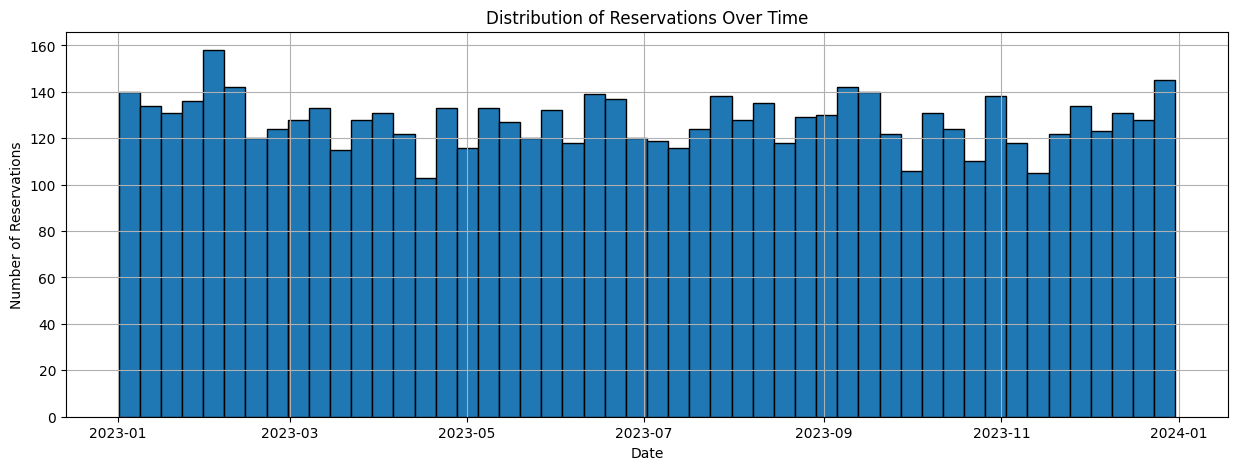

In [15]:
# Plot the distribution of reservations over time
plt.figure(figsize=(15, 5))
reservations_df['created_at'].hist(bins=50, edgecolor='black')
plt.title('Distribution of Reservations Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reservations')
plt.show()


In [16]:
# Calculate Pearson correlation matrix
pearson_correlation_matrix = merged_data.corr(method='pearson')

In [17]:
# Calculate Spearman correlation matrix
spearman_correlation_matrix = merged_data.corr(method='spearman')


In [18]:
# Filter and sort correlations with 'total_reservations' having absolute value > 0.2 for Pearson
pearson_correlation_with_total_reservations = pearson_correlation_matrix['total_reservations']
significant_pearson_correlations = pearson_correlation_with_total_reservations[abs(pearson_correlation_with_total_reservations) > 0.02]
significant_pearson_correlations = significant_pearson_correlations.abs().sort_values(ascending=False)


In [19]:
# Filter and sort correlations with 'total_reservations' having absolute value > 0.2 for Spearman
spearman_correlation_with_total_reservations = spearman_correlation_matrix['total_reservations']
significant_spearman_correlations = spearman_correlation_with_total_reservations[abs(spearman_correlation_with_total_reservations) > 0.02]
significant_spearman_correlations = significant_spearman_correlations.abs().sort_values(ascending=False)


In [20]:
# Display significant correlations
print("Variables with Pearson correlation > 0.2 with total_reservations (sorted by absolute value):")
print(significant_pearson_correlations)
print("\nVariables with Spearman correlation > 0.2 with total_reservations (sorted by absolute value):")
print(significant_spearman_correlations)

Variables with Pearson correlation > 0.2 with total_reservations (sorted by absolute value):
total_reservations    1.000000
actual_price          0.258907
num_images            0.219804
technology            0.136471
Name: total_reservations, dtype: float64

Variables with Spearman correlation > 0.2 with total_reservations (sorted by absolute value):
total_reservations    1.000000
num_images            0.246998
actual_price          0.226318
technology            0.104915
Name: total_reservations, dtype: float64


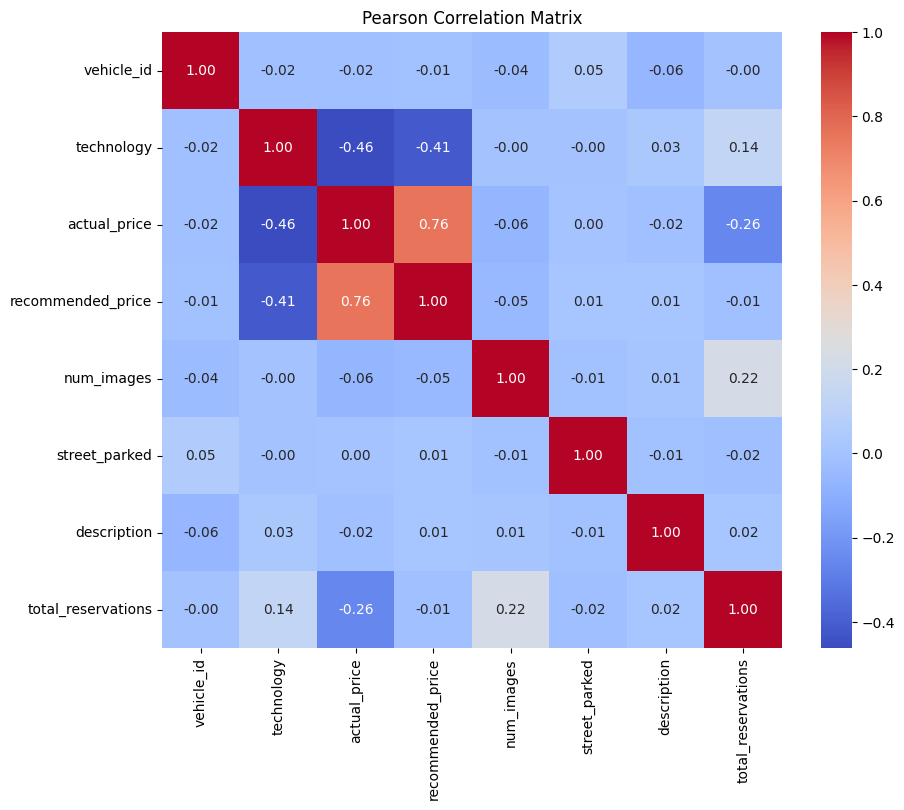

In [21]:
# Plotting the Pearson correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix')
plt.show()

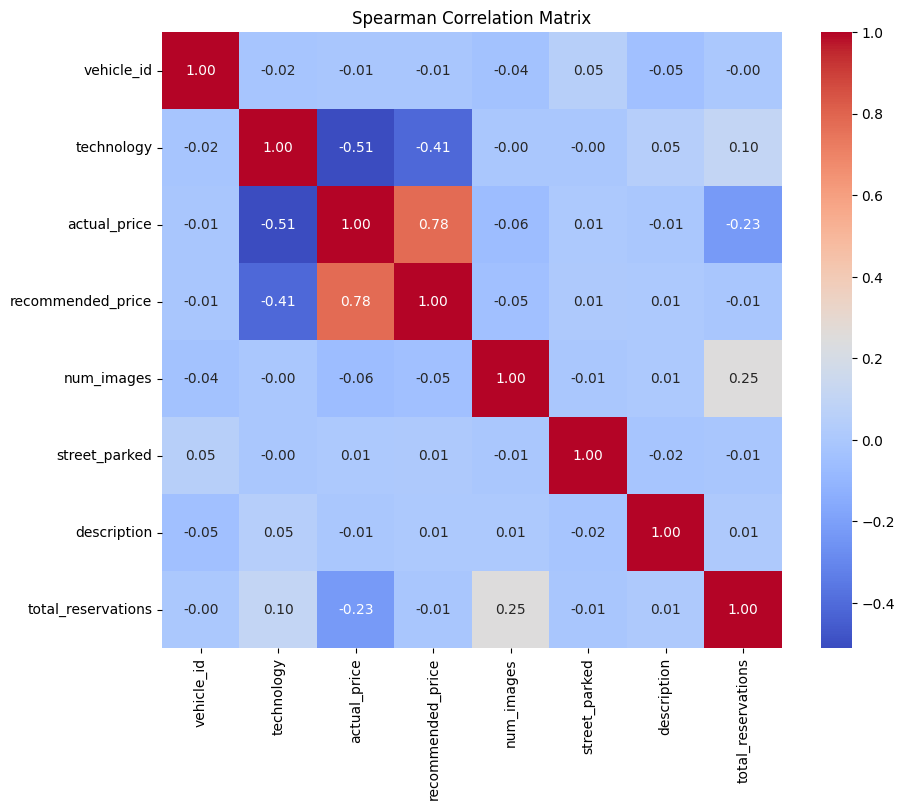

In [22]:
# Plotting the Spearman correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Matrix')
plt.show()

In [23]:
# Identify significant features based on Pearson correlation
significant_features = significant_pearson_correlations.index.tolist()
significant_features.remove('total_reservations')  # Remove the target variable

In [24]:
merged_data_significant_features = merged_data[significant_features].copy()
merged_data_significant_features['target'] = merged_data['total_reservations']

In [25]:
# Define features and target variable using only significant features
X = merged_data_significant_features.drop(columns=['target'])
y = merged_data_significant_features['target']

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
# Scale the data for deep learning
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [29]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

In [30]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = len(significant_features)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [31]:
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R-squared (R²): {r2}')
print(f'Adjusted R-squared: {adjusted_r2}')

Mean Squared Error (MSE): 20.86056773508234
Root Mean Squared Error (RMSE): 4.5673370507421875
Mean Absolute Error (MAE): 3.539326456352831
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R²): 0.10412376433503234
Adjusted R-squared: 0.09041137297281343


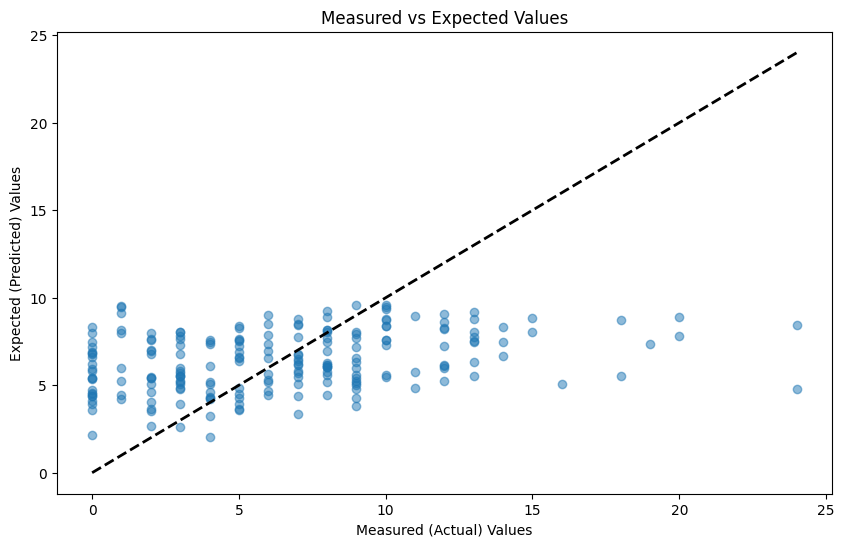

In [32]:
# Plot measured vs expected values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line y = x
plt.xlabel('Measured (Actual) Values')
plt.ylabel('Expected (Predicted) Values')
plt.title('Measured vs Expected Values')
plt.show()

In [33]:
# Define models and parameter grids for GridSearchCV
models = {
    "SVR": {
        "model": SVR(),
        "params": {
            'kernel': ['linear', 'rbf'],
            'C': [0.05, 0.1, 0.2],  # Around previous best: 0.1
            'epsilon': [0.05, 0.1, 0.15],  # Around previous best: 0.1
            'gamma': ['scale', 'auto', 0.1, 1]  # Adding specific gamma values
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42),
        "params": {
            'n_estimators': np.linspace(90, 120, 3, dtype=int),
            'max_depth': [1, 2, 3],
            'learning_rate': np.linspace(0.025, 0.05, 3),
            'subsample': np.linspace(0.6, 0.8, 3),
            'colsample_bytree': np.linspace(0.6, 0.8, 5),
            'reg_alpha': np.linspace(0.02, 0.1, 3),
            'reg_lambda': np.linspace(0.02, 0.1, 3)
        }
    },
    "CatBoost": {
        "model": CatBoostRegressor(random_state=42, silent=True),
        "params": {
            'iterations': np.linspace( 120, 150, 2, dtype=int),
            'depth': [2, 3, 4],
            'learning_rate': np.linspace(0.001, 0.02, 3),
            'l2_leaf_reg': np.linspace(0.5, 0.7, 10),
            'bagging_temperature': np.linspace(0, 0.1, 3)
        }
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            'n_neighbors': np.linspace(13, 40, 5, dtype=int),
            'weights': ['uniform', 'distance'],
            'p': [2, 3, 4,5,6,7,8,9,10]
        }
    },

    
}

In [34]:
# Perform GridSearchCV for each model
results = []
for name, config in models.items():
    if name == "Neural Network":
        grid_search = GridSearchCV(config["model"], config["params"], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    else:
        grid_search = GridSearchCV(config["model"], config["params"], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled if name == "Neural Network" else X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled if name == "Neural Network" else X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        "Model": name,
        "Best Params": grid_search.best_params_,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })





In [35]:
# Display results with full column width
pd.set_option('display.max_colwidth', None)
results_df = pd.DataFrame(results)
display(results_df)


,Model,Best Params,MSE,RMSE,MAE,R2
0,SVR,"{'C': 0.05, 'epsilon': 0.15, 'gamma': 'scale', 'kernel': 'linear'}",21.566959,4.644024,3.559183,0.073787
1,XGBoost,"{'colsample_bytree': 0.7, 'learning_rate': 0.025, 'max_depth': 2, 'n_estimators': 120, 'reg_alpha': 0.1, 'reg_lambda': 0.06, 'subsample': 0.6}",20.951630,4.577295,3.547846,0.100213
2,CatBoost,"{'bagging_temperature': 0.0, 'depth': 2, 'iterations': 150, 'l2_leaf_reg': 0.5, 'learning_rate': 0.02}",20.577541,4.536247,3.506218,0.116279
3,KNN,"{'n_neighbors': 26, 'p': 3, 'weights': 'uniform'}",21.983203,4.688625,3.668269,0.055911


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras import Sequential, layers, regularizers, callbacks, optimizers

# Create a simple neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),  # Using tanh activation
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),  # Using tanh activation
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/150


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-24 09:09:11.297826: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 61.9214 - val_loss: 70.7106
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.0468 - val_loss: 69.7823
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.1853 - val_loss: 68.7569
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.1997 - val_loss: 67.5470
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.9627 - val_loss: 66.0046
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.4084 - val_loss: 64.0560
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.4641 - val_loss: 61.7305
Epoch 8/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.1573 - val_loss: 58.8740
Epoch 9/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49.3753 - val_loss: 55.5325
Epoch 10/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.0494 - val_loss: 51.6375
Epoch 11/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.3471 - val_loss: 47.4128
Epoch 12/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

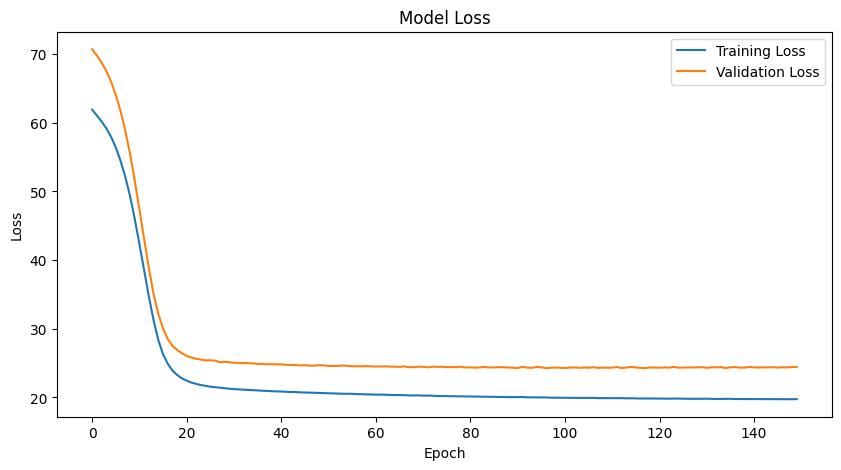

In [37]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Mean Squared Error (MSE): 21.12969139554655
Root Mean Squared Error (RMSE): 4.596704405935469
Mean Absolute Error (MAE): 3.5239765959978104
R-squared (R²): 0.0925660016256512


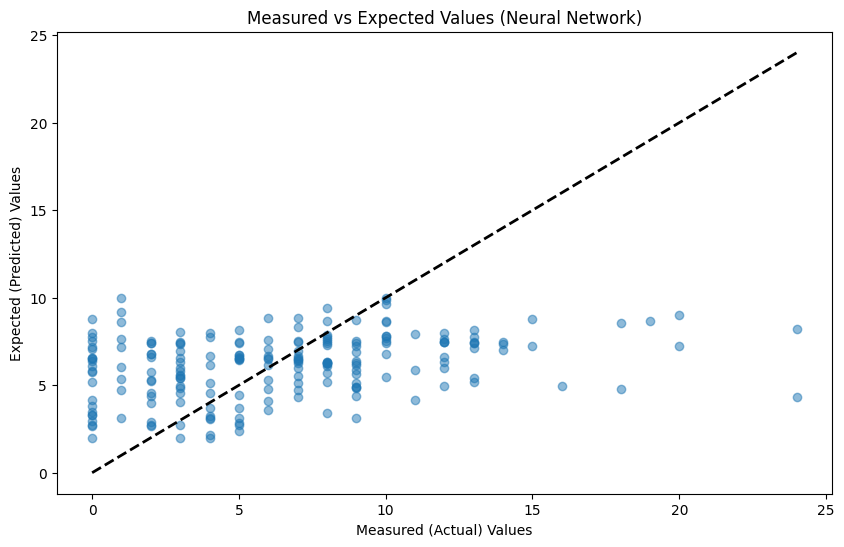

In [38]:
# Evaluate the model on the test set
y_pred = model.predict(X_test_scaled).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')

# Plot measured vs expected values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Measured (Actual) Values')
plt.ylabel('Expected (Predicted) Values')
plt.title('Measured vs Expected Values (Neural Network)')
plt.show()

Descriptive Statistics for 'total_reservations':
Mean: 6.376
Standard Deviation: 4.861301909597495
Minimum: 0.0
Maximum: 25.0
Median: 5.0


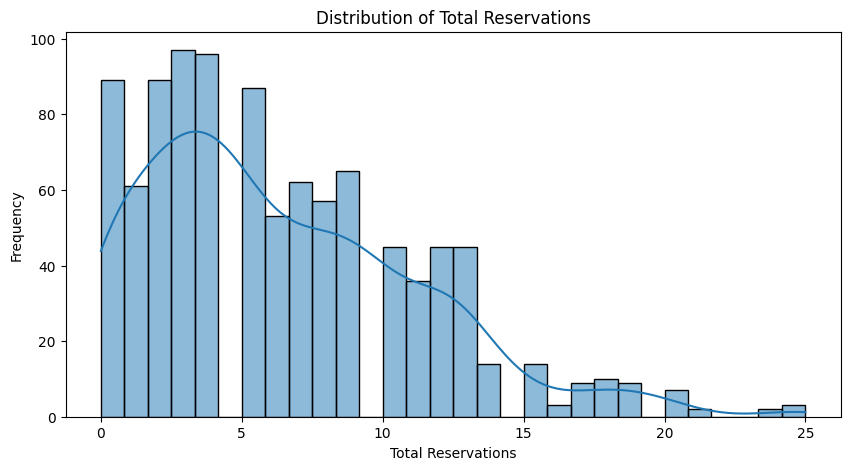

In [39]:
# Calculate mean and standard deviation of the target variable 'total_reservations'
mean_total_reservations = merged_data['total_reservations'].mean()
std_total_reservations = merged_data['total_reservations'].std()

# Display mean and standard deviation
print("Descriptive Statistics for 'total_reservations':")
print(f"Mean: {mean_total_reservations}")
print(f"Standard Deviation: {std_total_reservations}")

# Calculate additional statistics for better context
min_total_reservations = merged_data['total_reservations'].min()
max_total_reservations = merged_data['total_reservations'].max()
median_total_reservations = merged_data['total_reservations'].median()

print(f"Minimum: {min_total_reservations}")
print(f"Maximum: {max_total_reservations}")
print(f"Median: {median_total_reservations}")

# Plot the distribution of 'total_reservations'
plt.figure(figsize=(10, 5))
sns.histplot(merged_data['total_reservations'], kde=True, bins=30)
plt.title('Distribution of Total Reservations')
plt.xlabel('Total Reservations')
plt.ylabel('Frequency')
plt.show()
